# Lab-4

In [13]:
# 1. Генерація зображень
# Вирішіть завдання генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE), якщо в обраному датасеті багато класів, залиште декілька.
# Датасети: можна брати CIFAR-100, Fashion MNIST або тут: https://www.kaggle.com/tags/image-data  

# 2.  Вирішити завдання машинного перекладу (будь яка пара мов, датасети тут: https://www.manythings.org/anki/)
# Приклад: https://keras.io/examples/nlp/neural_machine_translation_with_transformer/ (English-to-Spanish не обирати!)

# 3. Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline або TFAutoModelForSequenceClassification
# Приклад: https://github.com/natsakh/Data-Analysis/blob/main/Pr_8/1%20hugging%20face%20transformers.ipynb

# 4. Бонус (не обов'язкова задача). Застосуйте pretrained BERT model для задачі класифікації текстів з лабораторної 2. 
# Приклад: https://github.com/natsakh/Data-Analysis/blob/main/Pr_8/2%20hugging%20face%20transformers.ipynb

# Як звіт – робочий код в Jupyter notebook заливаєте на свій репозиторій. Лінк відправляєте як відповідь до цього завдання.
# Максимальний бал – 10, 6 за роботу + 4 захист.
# Захистити роботу можна буде в грудні на практиці (якщо встигнете виконати) або на консультації перед екзаменом.
# (!) Захищати на консультації перед екзаменом можна буде тільки лаб 4, лаб 1, 2, 3 - тільки в семестрі, на практичних
# (!) Однакові або дуже схожі роботи прийматися не будуть.

# Datasets

In [14]:
# 1. Генерація зображень

#    Name: Tom and Jerry
#    Dataset: https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification?select=ground_truth.csv

# 2. Завдання машинного перекладу 

#    Name: Italian - English ita-eng.zip (46424)
#    Dataset: https://www.manythings.org/anki/


# Image generation

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import os, sys

import requests
import keras

from keras.utils import get_file

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras import layers
from keras.layers import TextVectorization, LeakyReLU, Conv2DTranspose, Embedding, Bidirectional, Reshape, Dense, BatchNormalization, LSTM
from keras.layers import GRU, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Dropout, MultiHeadAttention, LayerNormalization, Add, StringLookup
from keras import Sequential
from keras.models import save_model, load_model

import tensorflow as tf

import tensorflow_text as tf_text

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

from skimage import color
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

np.random.seed(1000)

/home/linux/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [16]:
mypath_class_1='archive/tom_and_jerry/tom_and_jerry/tom/'
mypath_class_2='archive/tom_and_jerry/tom_and_jerry/jerry/'

mypath_class_1_list = [mypath_class_1+f for f in listdir(mypath_class_1) if isfile(join(mypath_class_1, f))]
mypath_class_2_list = [mypath_class_2+f for f in listdir(mypath_class_2) if isfile(join(mypath_class_2, f))]

all_files=mypath_class_1_list+mypath_class_2_list

In [17]:
def image_transform(paths):
    x = []
    for path in paths:
        image = io.imread(path)
        image_res = resize(image, (32, 32), anti_aliasing=True)
        np_pic = np.array(image_res, dtype=np.float32)
        x.append(np_pic)
    return x

In [18]:
x=image_transform(all_files[0:1000])

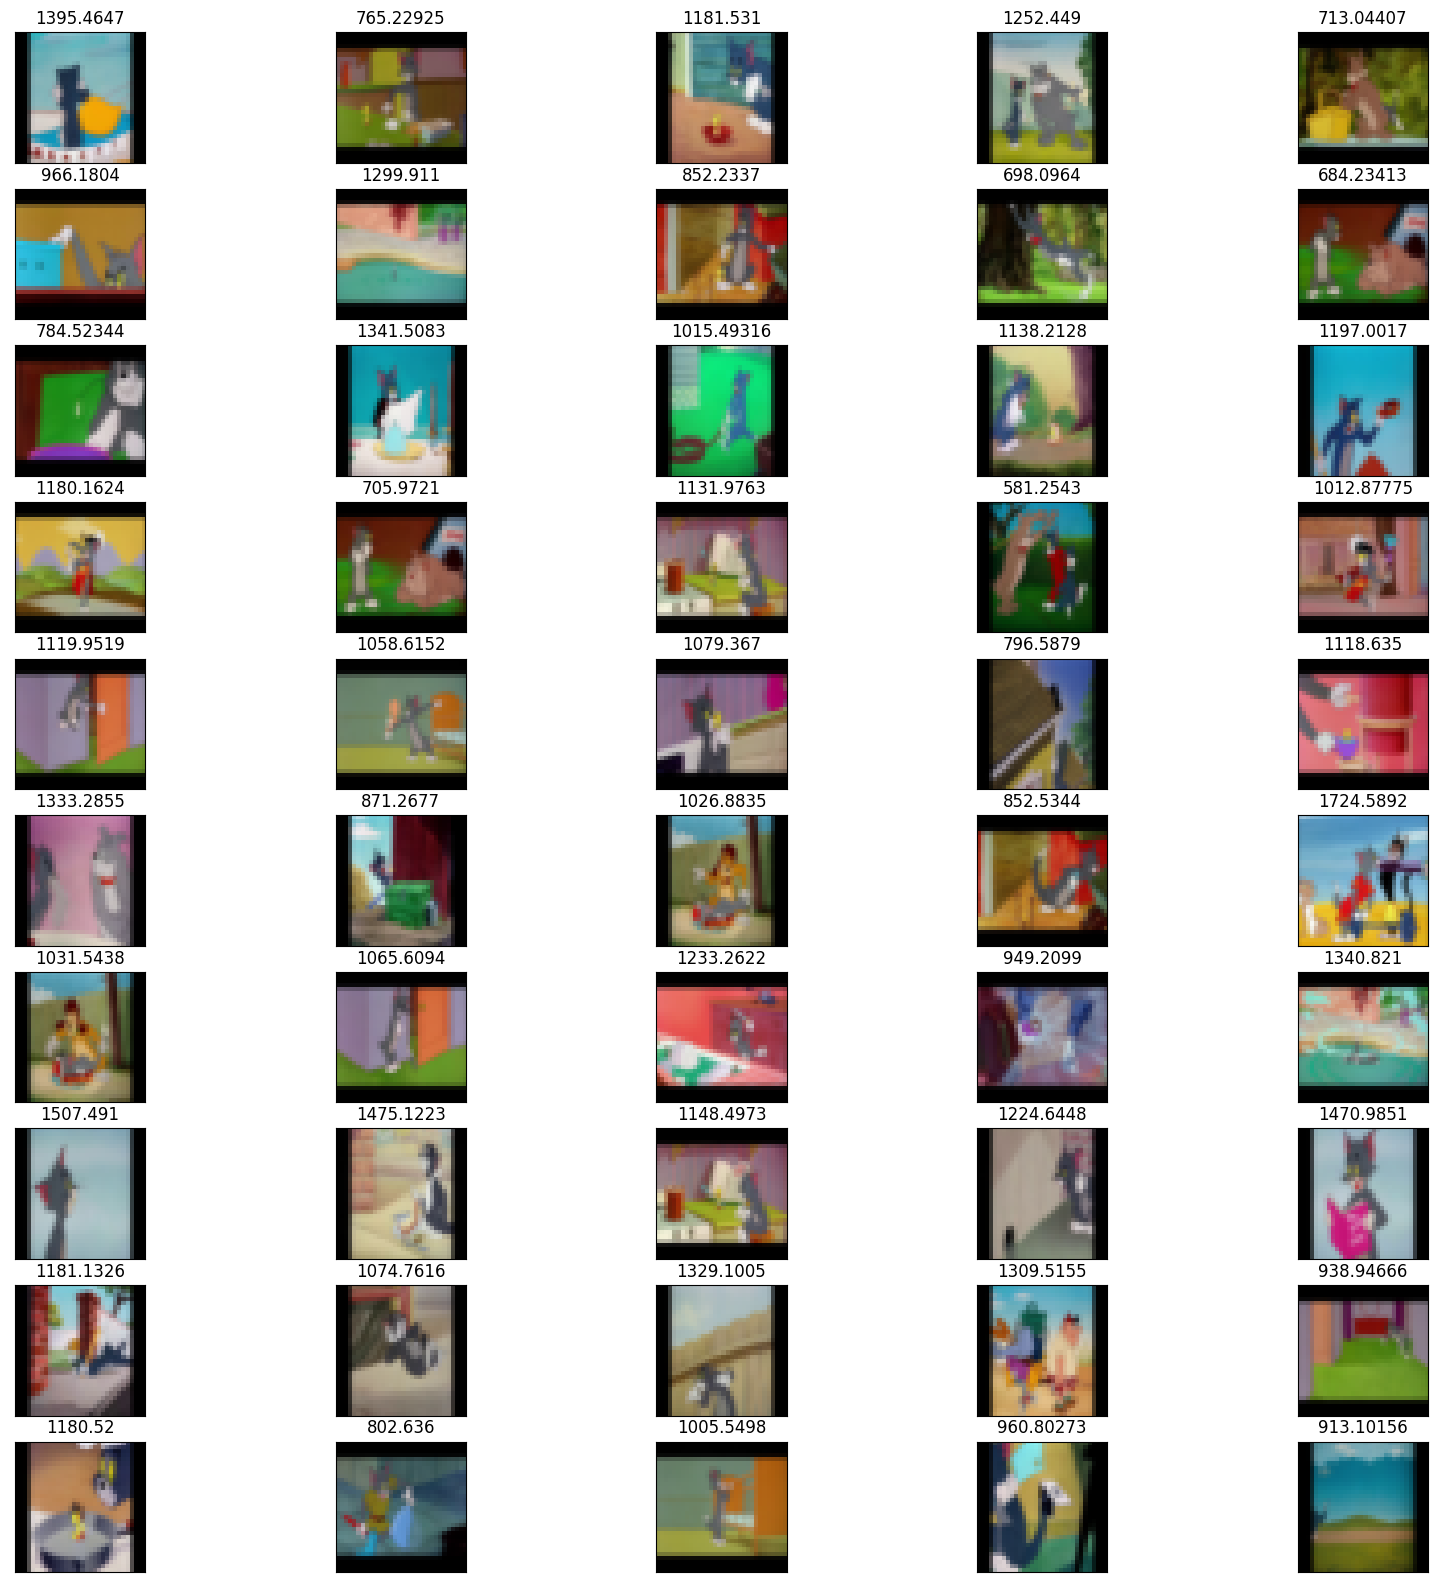

In [19]:
fig = plt.figure(figsize=(20,20))
for row in range(10):
    for column in range(5):
        i = row * 5 + column
        if i>len(x)-1:
            break                   
        ax = fig.add_subplot(10, 5, i+1)
        ax.set_title(str(np.sum(x[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(x[i])

In [20]:
latent_dim = 100

In [21]:
x_train = np.clip(x, -1, 1)

In [22]:
x_train.shape

(1000, 32, 32, 3)

In [23]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [24]:
def build_discriminator():
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

In [25]:
latent_dim = 100

def build_generator():
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model   

In [26]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [27]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [28]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [29]:
def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        with HiddenPrints():
            for i in range(num_batches):
                noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
                image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
                
                # Generate fake CIFAR images
                generated_images = generator.predict(noise)
                
                X = np.concatenate([image_batch, generated_images])

                # Labels for generated and real data
                y_dis = np.zeros(2*batch_size)
                y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
                # Train discriminator
                discriminator.trainable = True
                d_loss, _ = discriminator.train_on_batch(X, y_dis)
                discrim_losses.append(d_loss)

                # Train generator
                noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
                y_gen = np.ones(batch_size)
                discriminator.trainable = False
                gan.train_on_batch(noise, y_gen)
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)
            tf.keras.backend.clear_session()  

2022-12-23 21:06:45.320183: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:06:46.552414: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]


2022-12-23 21:06:49.741799: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:06:50.441295: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:06:52.946844: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:06:53.682033: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  0
1/1 [==============================] - 0s 88ms/step


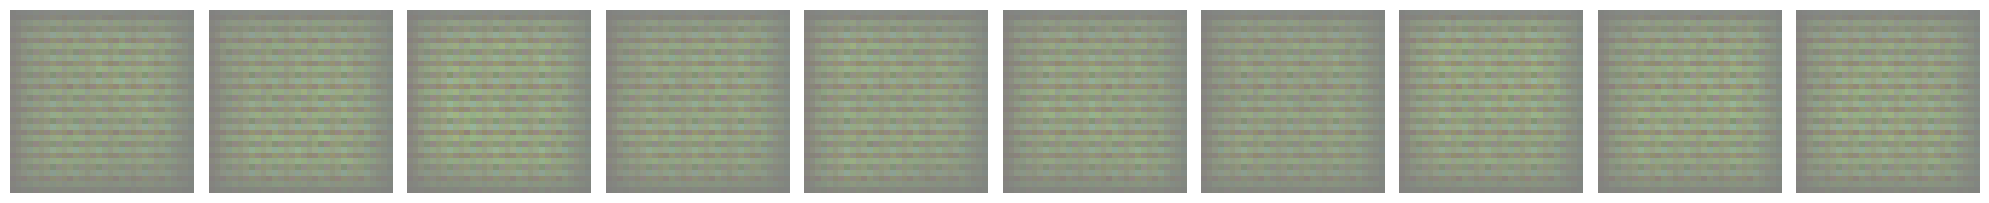

2022-12-23 21:07:19.441643: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:07:20.276884: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:07:22.914735: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:07:23.655330: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  10
1/1 [==============================] - 0s 92ms/step


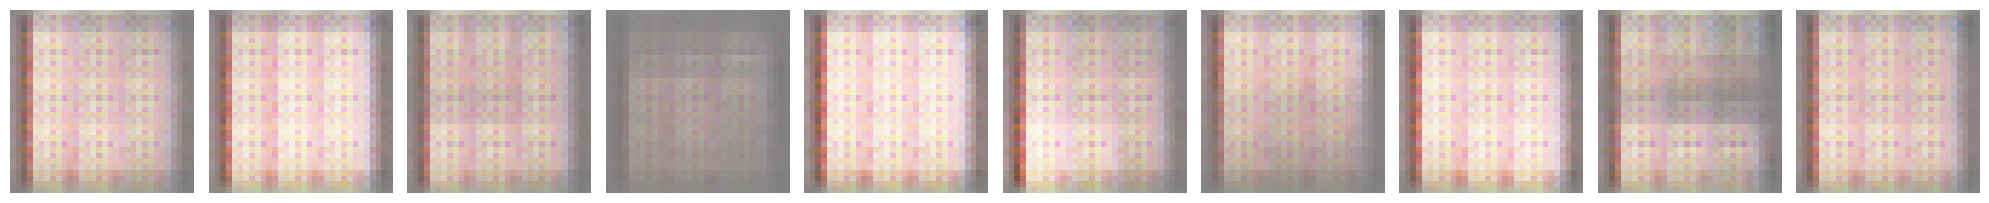

2022-12-23 21:12:38.007189: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:12:38.842238: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:12:41.435099: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:12:42.175387: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  20
1/1 [==============================] - 0s 92ms/step


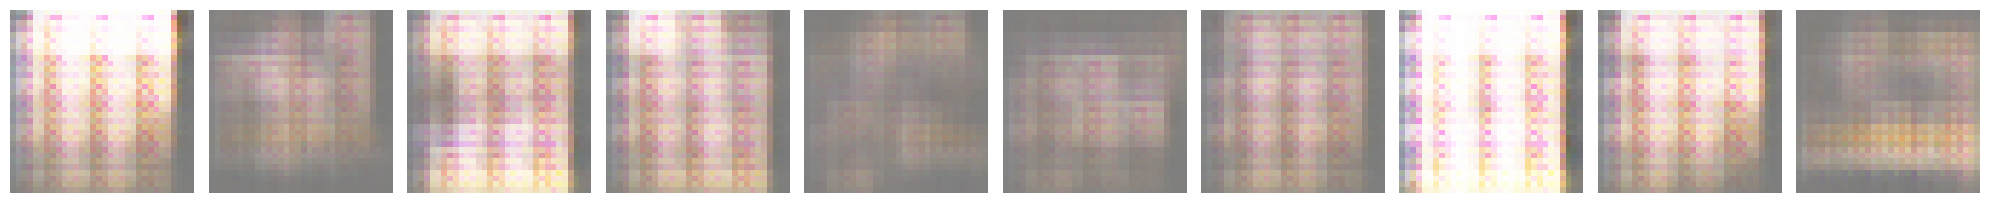

2022-12-23 21:17:56.063955: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:17:56.896268: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:17:59.493015: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:18:00.204837: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  30
1/1 [==============================] - 0s 91ms/step


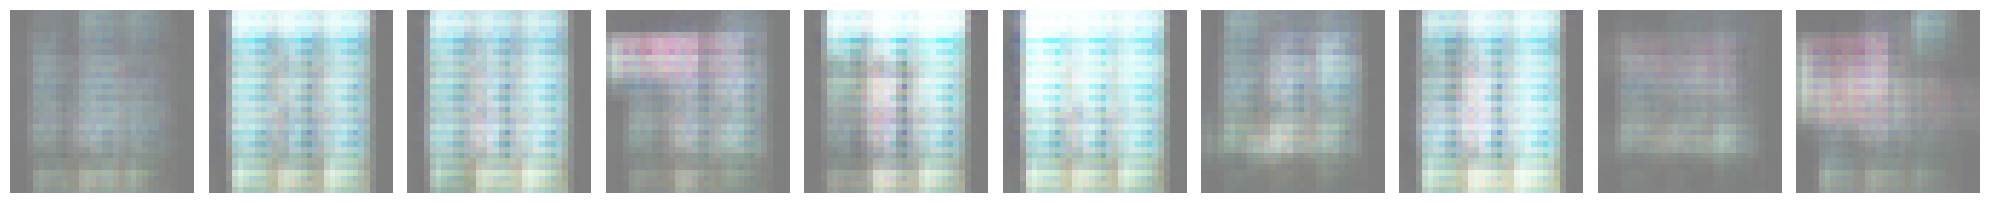

2022-12-23 21:23:20.042564: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:23:20.862889: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:23:23.514944: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:23:24.223873: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  40
1/1 [==============================] - 0s 93ms/step


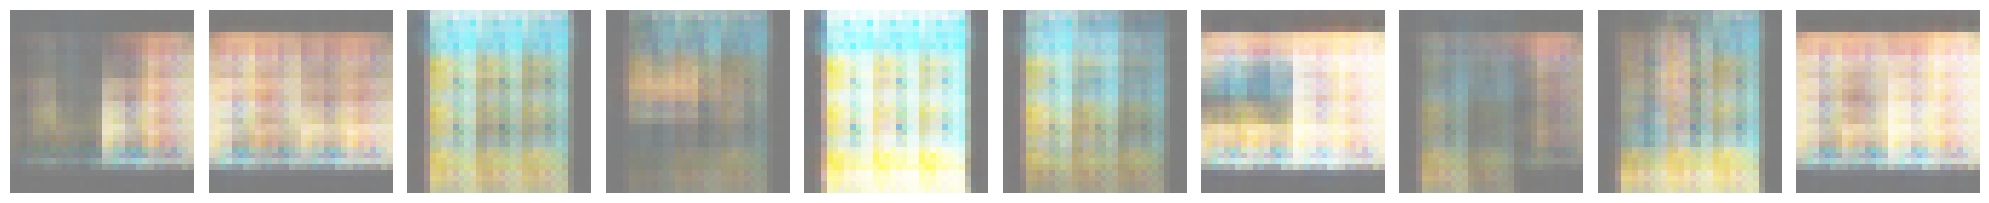

2022-12-23 21:28:42.576744: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:28:43.416936: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:28:46.043574: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:28:46.746765: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  50
1/1 [==============================] - 0s 87ms/step


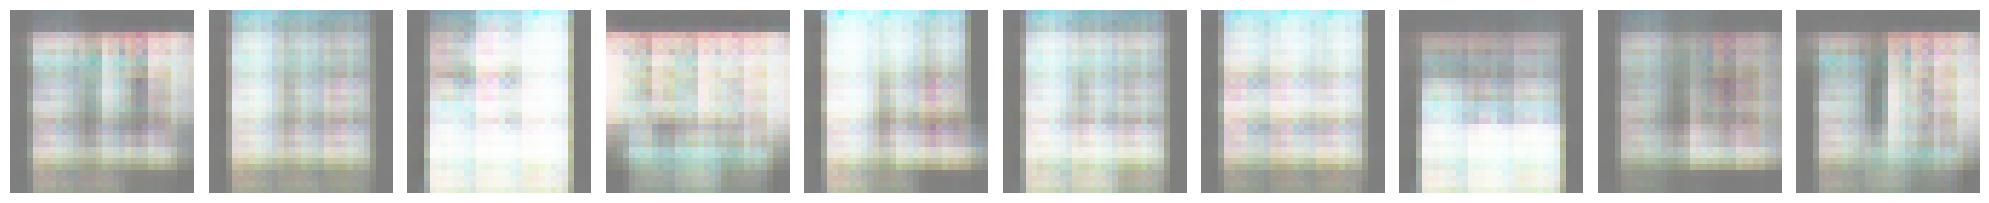

2022-12-23 21:34:05.228459: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:34:06.064133: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:34:08.745175: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:34:09.463718: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  60
1/1 [==============================] - 0s 87ms/step


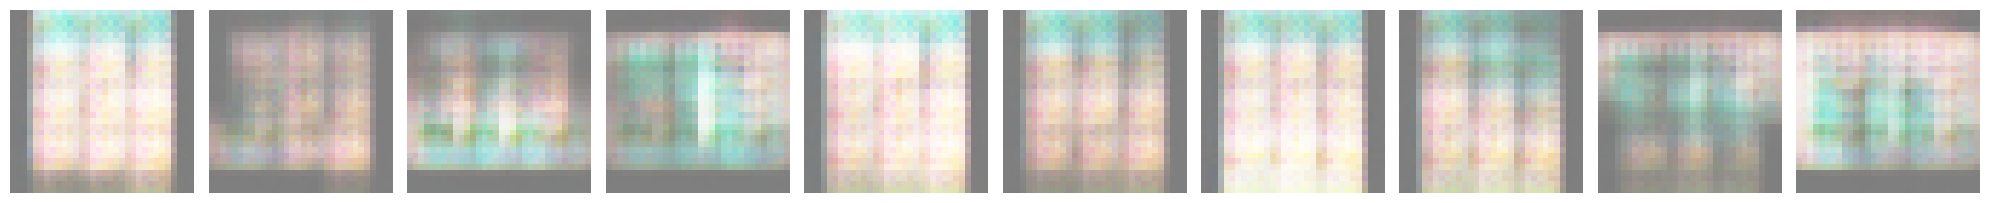

2022-12-23 21:39:33.678989: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:39:34.525125: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:39:37.172774: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:39:37.880479: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  70
1/1 [==============================] - 0s 86ms/step


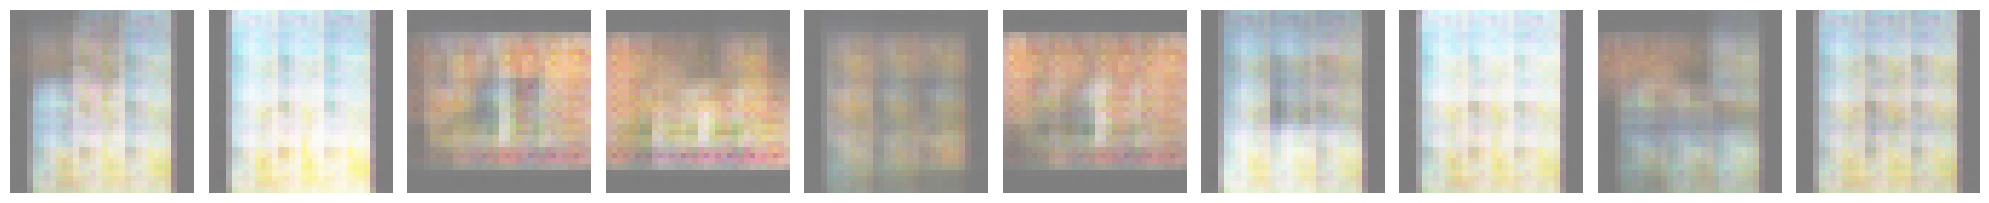

2022-12-23 21:44:55.937746: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:44:56.862213: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:44:59.554161: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:45:00.268899: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  80
1/1 [==============================] - 0s 87ms/step


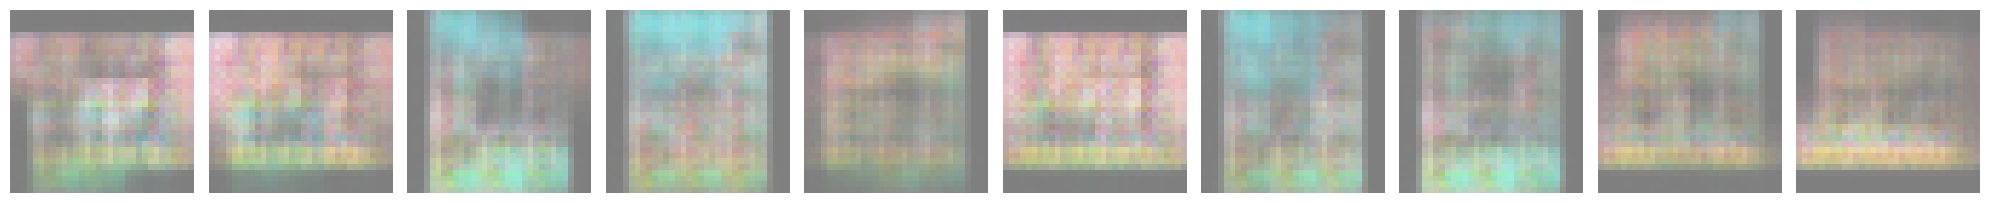

2022-12-23 21:50:17.379561: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:50:18.325217: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:50:20.997964: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:50:21.700116: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  90
1/1 [==============================] - 0s 93ms/step


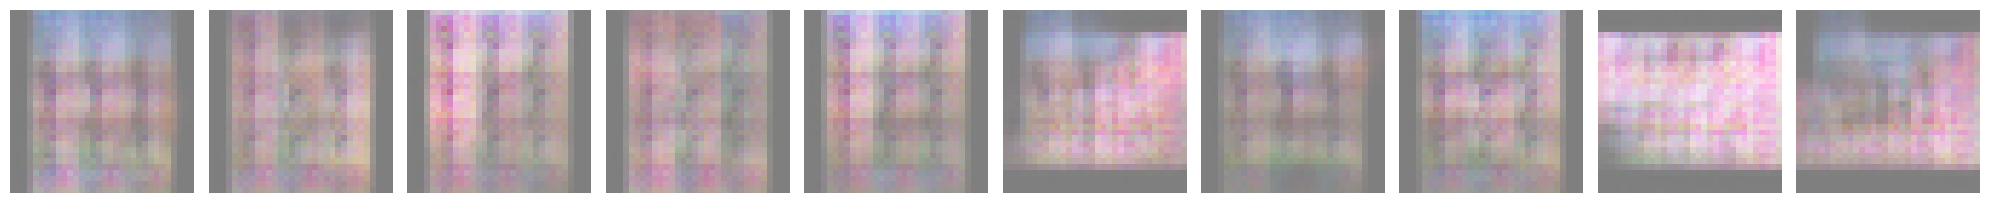

2022-12-23 21:55:38.484102: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:55:39.323068: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:55:41.954199: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 21:55:42.673412: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  100
1/1 [==============================] - 0s 94ms/step


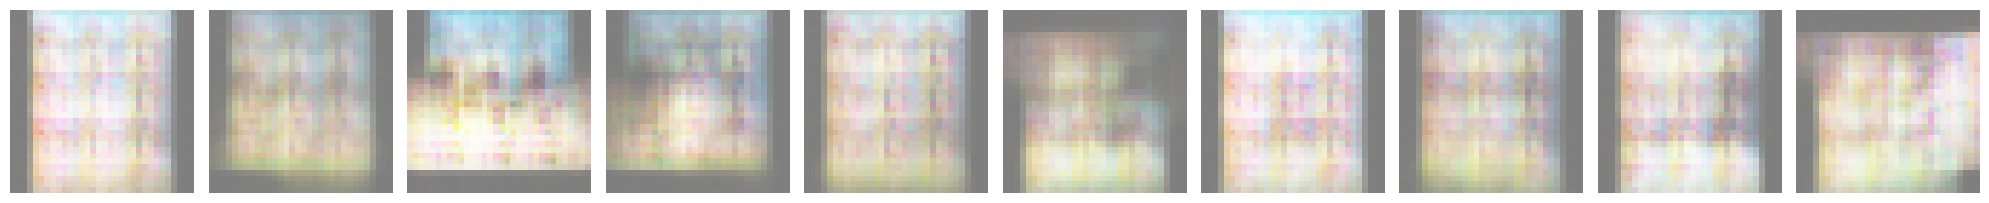

2022-12-23 22:00:58.451039: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 22:00:59.280680: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 22:01:01.981121: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 22:01:02.678508: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  110
1/1 [==============================] - 0s 89ms/step


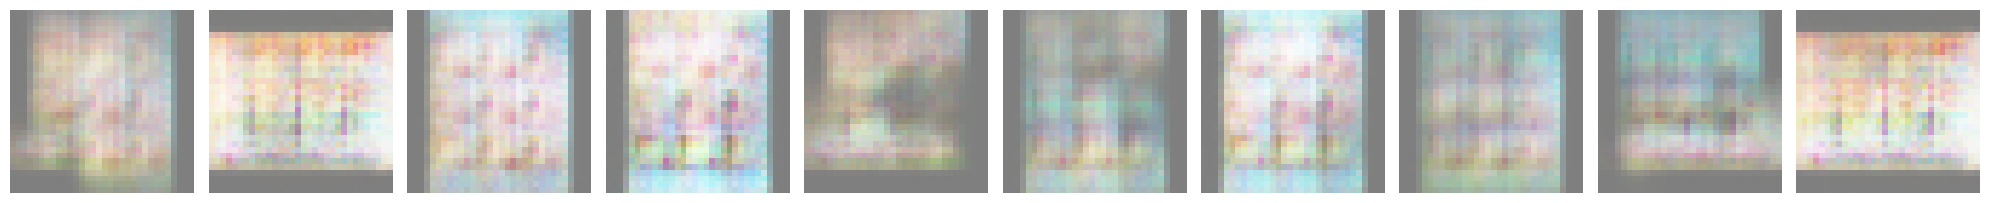

2022-12-23 22:06:18.307512: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 22:06:19.160693: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [100]
	 [[{{node Placeholder/_1}}]]
2022-12-23 22:06:21.787545: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200]
	 [[{{node Placeholder/_1}}]]
2022-12-23 22:06:22.489093: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype 

epoch:  120
1/1 [==============================] - 0s 89ms/step


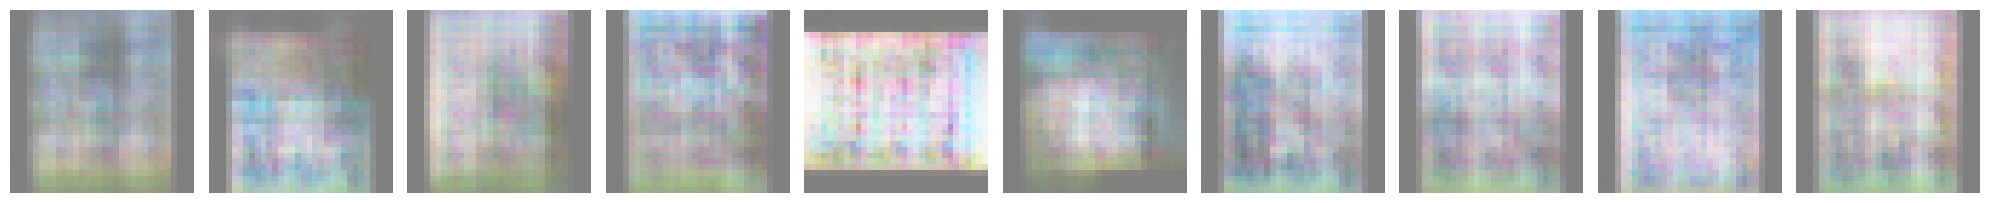

In [32]:
discrim_losses = []
acc = []
all_images = []

discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)


epochs = 120# to get good quality images, you should train the model for more than 100 epochs
batch_size = 100
train_model(epochs, batch_size)

# Machine translation

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

import keras_nlp
import numpy as np
import pathlib
import random
import tensorflow as tf

from tensorflow import keras
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

2022-12-24 16:05:38.039636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 16:05:41.542590: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-24 16:05:41.543248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-24 16:05:43.069358: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay
2022-12-24 16:05:48.223704: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8';

In [2]:
text_file = pathlib.Path('/home/linux/Documents/Intelligent-Data-Analysis/Lab-4/ita-eng/ita.txt')

In [3]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []

In [4]:
for line in lines:
    eng, pol, error  = line.split("\t")
    eng = eng.lower()
    pol = pol.lower()
    pol = "[start] " + pol + " [end]"
    text_pairs.append((eng, pol))

In [5]:
text_pairs

[('hi.', '[start] ciao! [end]'),
 ('hi.', '[start] ciao. [end]'),
 ('run!', '[start] corri! [end]'),
 ('run!', '[start] corra! [end]'),
 ('run!', '[start] correte! [end]'),
 ('who?', '[start] chi? [end]'),
 ('wow!', '[start] wow! [end]'),
 ('duck!', '[start] amore! [end]'),
 ('duck!', '[start] tesoro! [end]'),
 ('duck!', '[start] immergiti! [end]'),
 ('duck!', '[start] si immerga! [end]'),
 ('duck!', '[start] immergetevi! [end]'),
 ('duck!', '[start] tuffati! [end]'),
 ('duck!', '[start] si tuffi! [end]'),
 ('duck!', '[start] tuffatevi! [end]'),
 ('jump!', '[start] salta! [end]'),
 ('jump!', '[start] salti! [end]'),
 ('jump!', '[start] saltate! [end]'),
 ('jump.', '[start] salta. [end]'),
 ('jump.', '[start] salti. [end]'),
 ('jump.', '[start] saltate. [end]'),
 ('stay.', '[start] resta. [end]'),
 ('stay.', '[start] stai. [end]'),
 ('stay.', '[start] stia. [end]'),
 ('stay.', '[start] state. [end]'),
 ('stay.', '[start] resti. [end]'),
 ('stay.', '[start] restate. [end]'),
 ('stay.', '

In [6]:
for _ in range(5):
    print(random.choice(text_pairs))

("i'm all alone now.", '[start] io sono completamente sola adesso. [end]')
('tom readily admits his mistakes.', '[start] tom ammette rapidamente i suoi errori. [end]')
('i have throat cancer.', '[start] io ho un tumore alla gola. [end]')
("we're waiting for the pizza to arrive.", '[start] stiamo aspettando che arrivi la pizza. [end]')
('i have yet to find a perfect husband.', '[start] io devo ancora trovare un marito perfetto. [end]')


In [7]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

358373 total pairs
250863 training pairs
53755 validation pairs
53755 test pairs


In [8]:
BATCH_SIZE = 64
EPOCHS = 1  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 40
ENG_VOCAB_SIZE = 15000
SPA_VOCAB_SIZE = 15000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [9]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    bert_vocab_args = dict(
        # The target vocabulary size
        vocab_size=vocab_size,
        # Reserved tokens that must be included in the vocabulary
        reserved_tokens=reserved_tokens,
        # Arguments for `text.BertTokenizer`
        bert_tokenizer_params={"lower_case": True},
    )

    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = bert_vocab.bert_vocab_from_dataset(
        word_piece_ds.batch(1000).prefetch(2), **bert_vocab_args
    )
    return vocab

In [10]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = [text_pair[0] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, ENG_VOCAB_SIZE, reserved_tokens)

spa_samples = [text_pair[1] for text_pair in train_pairs]
spa_vocab = train_word_piece(spa_samples, SPA_VOCAB_SIZE, reserved_tokens)

2022-12-24 16:05:57.456109: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-24 16:05:57.456146: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-24 16:05:57.456189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux-GA-78LMT-USB3-R2): /proc/driver/nvidia/version does not exist
2022-12-24 16:05:57.518057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 16:05:59.364663: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU

In [11]:
print("English Tokens: ", eng_vocab[100:110])
print("Spanish Tokens: ", spa_vocab[100:110])

English Tokens:  ['and', 'how', 'will', 'there', 'has', 'about', 'now', 'isn', 'all', 'going']
Spanish Tokens:  ['mio', 'mai', 'vero', 'sia', 'voglio', 'casa', 'penso', 'cosi', 'ancora', 'del']


In [12]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)
spa_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=spa_vocab, lowercase=False
)

In [13]:
eng_input_ex = text_pairs[0][0]
eng_tokens_ex = eng_tokenizer.tokenize(eng_input_ex)
print("English sentence: ", eng_input_ex)
print("Tokens: ", eng_tokens_ex)
print("Recovered text after detokenizing: ", eng_tokenizer.detokenize(eng_tokens_ex))

print()

spa_input_ex = text_pairs[0][1]
spa_tokens_ex = spa_tokenizer.tokenize(spa_input_ex)
print("Spanish sentence: ", spa_input_ex)
print("Tokens: ", spa_tokens_ex)
print("Recovered text after detokenizing: ", spa_tokenizer.detokenize(spa_tokens_ex))


English sentence:  i'm sure tom is wrong.
Tokens:  tf.Tensor([ 34   8  38 175  56  59 267  11], shape=(8,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b"i ' m sure tom is wrong .", shape=(), dtype=string)

Spanish sentence:  [start] sono sicuro che tom ha torto. [end]
Tokens:  tf.Tensor([ 26  58  27  68 217  62  59  67 965  11  26  57  27], shape=(13,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'[ start ] sono sicuro che tom ha torto . [ end ]', shape=(), dtype=string)


In [14]:
def preprocess_batch(eng, spa):
    batch_size = tf.shape(spa)[0]

    eng = eng_tokenizer(eng)
    spa = spa_tokenizer(spa)

    # Pad `eng` to `MAX_SEQUENCE_LENGTH`.
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=eng_tokenizer.token_to_id("[PAD]"),
    )
    eng = eng_start_end_packer(eng)

    # Add special tokens (`"[START]"` and `"[END]"`) to `spa` and pad it as well.
    spa_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=spa_tokenizer.token_to_id("[START]"),
        end_value=spa_tokenizer.token_to_id("[END]"),
        pad_value=spa_tokenizer.token_to_id("[PAD]"),
    )
    spa = spa_start_end_packer(spa)

    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [15]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

2022-12-24 16:08:30.788337: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [250863]
	 [[{{node Placeholder/_0}}]]
2022-12-24 16:08:30.789267: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype uint8 and shape [563396]
	 [[{{node Placeholder/_7}}]]


inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


2022-12-24 16:08:32.719046: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ENG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=SPA_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(SPA_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)

/home/linux/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [17]:
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding (  (None, None, 256)   3850240     ['encoder_inputs[0][0]']         
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   1315072     ['token_and_position_em

2022-12-24 16:08:35.349912: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [250863]
	 [[{{node Placeholder/_1}}]]
2022-12-24 16:08:35.350675: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [250863]
	 [[{{node Placeholder/_1}}]]


3920/3920 [==============================] - ETA: 0s - loss: 1.4774 - accuracy: 0.7658

2022-12-24 19:13:59.267396: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype uint8 and shape [395440]
	 [[{{node Placeholder/_6}}]]
2022-12-24 19:13:59.268053: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [53755]
	 [[{{node Placeholder/_1}}]]


3920/3920 [==============================] - 12162s 3s/step - loss: 1.4774 - accuracy: 0.7658 - val_loss: 0.9357 - val_accuracy: 0.8326


In [18]:
def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = eng_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def token_probability_fn(decoder_input_tokens):
        return transformer([encoder_input_tokens, decoder_input_tokens])[:, -1, :]

    # Set the prompt to the "[START]" token.
    prompt = tf.fill((batch_size, 1), spa_tokenizer.token_to_id("[START]"))

    generated_tokens = keras_nlp.utils.greedy_search(
        token_probability_fn,
        prompt,
        max_length=40,
        end_token_id=spa_tokenizer.token_to_id("[END]"),
    )
    generated_sentences = spa_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(10):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    translated = (
        translated.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )
    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)
    print()

** Example 0 **
tom has already left.
[ start ] tom ha gia lasciato . [ end ]

** Example 1 **
i think tom is forgetful.
[ start ] penso che tom sia sulla scrivania . [ end ]

** Example 2 **
it wasn't tom.
[ start ] non era tom . [ end ]

** Example 3 **
everyone looked unhappy.
[ start ] tutti erano infelice . [ end ]

** Example 4 **
i know you're listening.
[ start ] so che stai ascoltando . [ end ]

** Example 5 **
at what time does your class end?
[ start ] a che ora fa la sua lezione ? [ end ]

** Example 6 **
are you for or against this?
[ start ] sei favorevole o contro questo ? [ end ]

** Example 7 **
where are my things?
[ start ] dove sono le cose ? [ end ]

** Example 8 **
don't lean against the wall.
[ start ] non ammira contro la muro . [ end ]

** Example 9 **
she killed herself yesterday.
[ start ] lei si e ucciso ieri . [ end ]



# HF Transformers 

In [19]:
# Positive and negative sentences

In [20]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

In [21]:
positive = ' For 20 years, our positive news from around the world has uplifted and inspired millions to become more optimistic.'
classifier(positive)

[{'label': 'POSITIVE', 'score': 0.9997462630271912}]

In [22]:
negative = 'I am not flying to England.'
classifier(negative)

[{'label': 'NEGATIVE', 'score': 0.9992954730987549}]

In [23]:
positive_more_than_negative = 'My first day of school was more good than bad.'
classifier(positive_more_than_negative)

[{'label': 'POSITIVE', 'score': 0.9983526468276978}]

In [24]:
negative_more_than_positive = 'This work was made with many mistakes, and only little bit of code is good.'
classifier(negative_more_than_positive)

[{'label': 'NEGATIVE', 'score': 0.9987537860870361}]

In [25]:
# Text generation

In [26]:
text_generator = pipeline("text-generation", model = "sshleifer/tiny-gpt2")

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at sshleifer/tiny-gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [27]:
text = text_generator(
    'My first day of school was more good than bad.',
    max_length = 200,
    num_return_sequences = 1,
)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [28]:
text

[{'generated_text': 'My first day of school was more good than bad.---------- capability prohibit\x19oubathingFindhhhhoub Pick214 headsets sorry delve Rig lovingFindavier capability survivesyright available Pick Islandech temperatures var quest Hyd Athletics Twe DirectX quest sorry Weasleyonementhhhh Rig go concentration214 CarnivalRew sorryFind crappy temperatures pictureshhhh�imoreepisode flaredonement214 expothes capabilityhhhh214hhhh sorryothes concentration214onement214 Rig\x19 Weasley concentration Rig crappy temperaturesweedathing\x19 concentrationoubhhhhFind varoub capability availableweedweed treatment goyrightathing readityothesimoreimore crappy temperatures exp DirectX questavier Tourism Weasley sorry crappyhhhhityoubRew treatmentechyright214 flaredavier\x19 Rig Islandimore var� flared expavier flared read---------- sorry survives treatment Island Pickech capability survives DirectX flared algorithmsonement read prohibitoub Tourism sorryechityavier DirectX headsets� questath

In [29]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [30]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_47']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
classifier = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)

In [32]:
positive = ' For 20 years, our positive news from around the world has uplifted and inspired millions to become more optimistic.'
classifier(positive)

[{'label': 'POSITIVE', 'score': 0.9997462630271912}]

In [33]:
negative = 'I am not flying to England.'
classifier(negative)

[{'label': 'NEGATIVE', 'score': 0.9992954730987549}]

In [34]:
positive_more_than_negative = 'My first day of school was more good than bad.'
classifier(positive_more_than_negative)

[{'label': 'POSITIVE', 'score': 0.9983526468276978}]

In [35]:
negative_more_than_positive = 'This work was made with many mistakes, and only little bit of code is good.'
classifier(negative_more_than_positive)

[{'label': 'NEGATIVE', 'score': 0.9987537860870361}]

In [36]:
inputs = tokenizer([positive, negative])
inputs

{'input_ids': [[101, 2005, 2322, 2086, 1010, 2256, 3893, 2739, 2013, 2105, 1996, 2088, 2038, 2039, 18412, 2098, 1998, 4427, 8817, 2000, 2468, 2062, 21931, 1012, 102], [101, 1045, 2572, 2025, 3909, 2000, 2563, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [37]:
tokens = tokenizer.tokenize(positive)
print(tokens)

print(tokenizer.convert_tokens_to_ids(tokens))
print(tokenizer.decode(tokenizer.convert_tokens_to_ids(tokens)))

['for', '20', 'years', ',', 'our', 'positive', 'news', 'from', 'around', 'the', 'world', 'has', 'up', '##lift', '##ed', 'and', 'inspired', 'millions', 'to', 'become', 'more', 'optimistic', '.']
[2005, 2322, 2086, 1010, 2256, 3893, 2739, 2013, 2105, 1996, 2088, 2038, 2039, 18412, 2098, 1998, 4427, 8817, 2000, 2468, 2062, 21931, 1012]
for 20 years, our positive news from around the world has uplifted and inspired millions to become more optimistic.


# Sources

https://keras.io/examples/nlp/neural_machine_translation_with_keras_nlp/

https://github.com/natsakh/Data-Analysis/blob/main/Pr_9/9.2%20DCGAN%20CIFAR-10.ipynb

https://github.com/natsakh/Data-Analysis/blob/main/Pr_8/1%20hugging%20face%20transformers.ipynb

